In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\franco\AppData\Local\Temp\ipykernel_4724\2201947748.py:2: SyntaxWarning: invalid escape sequence '\m'
  image_path = 'archivos\monedas.jpg'


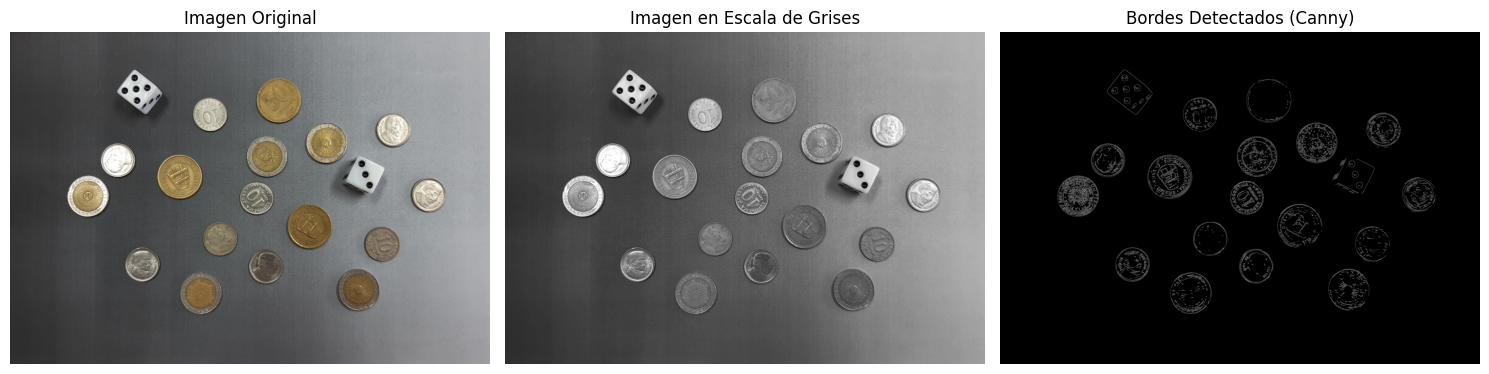

In [51]:
# Cargar la imagen proporcionada
image_path = 'archivos\monedas.jpg'
image = cv2.imread(image_path)

# Convertir la imagen a escala de grises para simplificar el procesamiento
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar un desenfoque para reducir el ruido y facilitar la segmentación
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Detectar bordes utilizando Canny Edge Detection
edges = cv2.Canny(blurred_image, 80, 180)

# Dilatar los bordes para unir fragmentos cercanos
dilated_edges = cv2.dilate(edges, None, iterations=15)

# Mostrar la imagen original, en escala de grises, y los bordes detectados
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Imagen Original")
ax[0].axis("off")

ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title("Imagen en Escala de Grises")
ax[1].axis("off")

ax[2].imshow(edges, cmap='gray')
ax[2].set_title("Bordes Detectados (Canny)")
ax[2].axis("off")

plt.tight_layout()
plt.show()


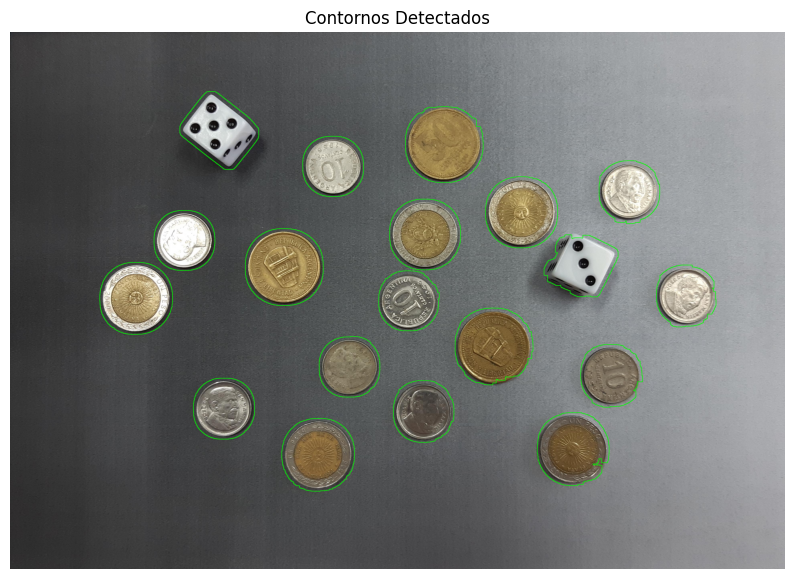

Tenemos un total de 19 objetos detectados.


In [99]:
# Realizar una segmentación utilizando detección de contornos
# Encontrar los contornos en la imagen de bordes
contours, _ = cv2.findContours(dilated_edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una copia de la imagen original para dibujar los contornos detectados
contour_image = image.copy()

# Dibujar todos los contornos detectados
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos dibujados
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Contornos Detectados")
plt.axis("off")
plt.show()

# Número total de objetos detectados
num_objects = len(contours)
print(f'Tenemos un total de {num_objects} objetos detectados.')


In [53]:
# Recortar cada contorno detectado y guardarlo en una lista
recortes = []
for i, contour in enumerate(contours):
    # Obtener el rectángulo delimitador para cada contorno
    x, y, w, h = cv2.boundingRect(contour)
    
    # Recortar la región del contorno de la imagen original
    recorte = edges[y:y+h, x:x+w]
    recortes.append(recorte)
    
    # Mostrar el recorte individual
    """ plt.figure()
    plt.imshow(cv2.cvtColor(recorte, cv2.COLOR_BGR2RGB))
    plt.title(f"Recorte del Contorno {i + 1}")
    plt.axis("off")
    plt.show()"""

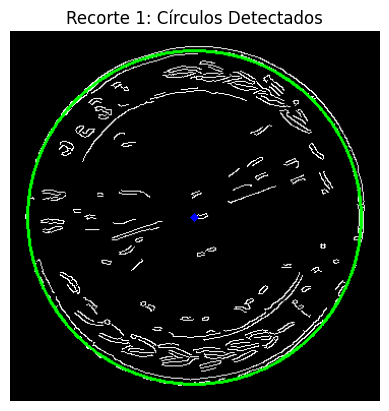

Recorte 1:
  Centro=(181, 183), Radio=164, Área=84496.28


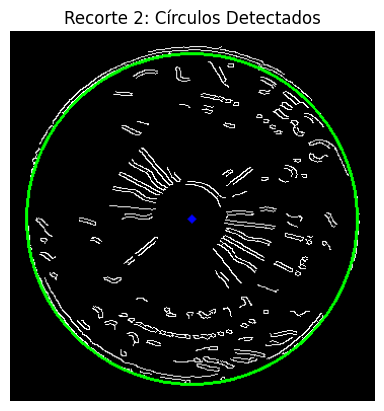

Recorte 2:
  Centro=(179, 185), Radio=163, Área=83468.98


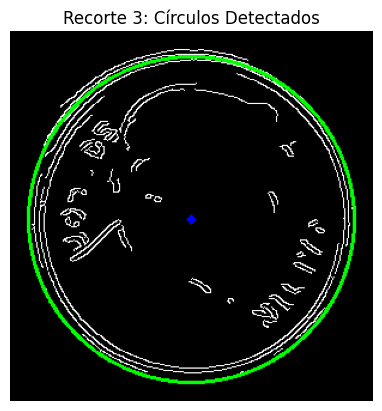

Recorte 3:
  Centro=(151, 157), Radio=136, Área=58106.90


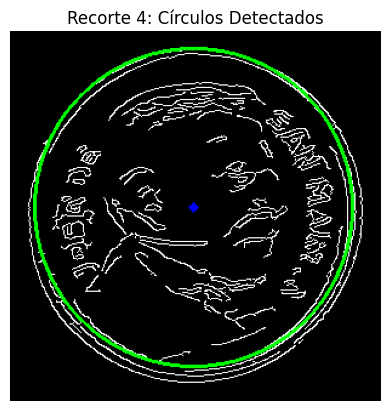

Recorte 4:
  Centro=(151, 145), Radio=131, Área=53912.87


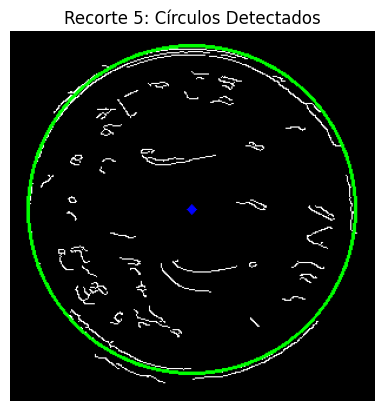

Recorte 5:
  Centro=(154, 151), Radio=139, Área=60698.71


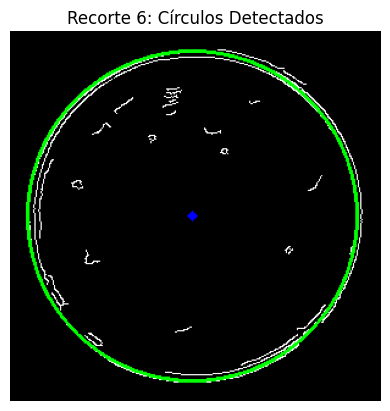

Recorte 6:
  Centro=(149, 151), Radio=135, Área=57255.53


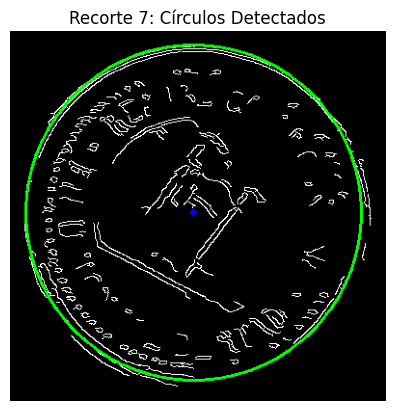

Recorte 7:
  Centro=(190, 188), Radio=174, Área=95114.86


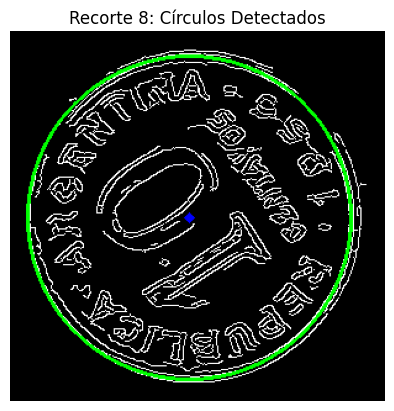

Recorte 8:
  Centro=(145, 151), Radio=131, Área=53912.87


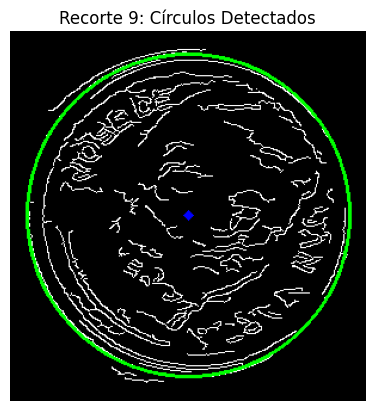

Recorte 9:
  Centro=(149, 154), Radio=135, Área=57255.53


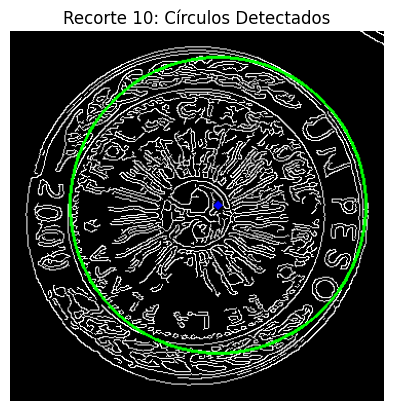

Recorte 10:
  Centro=(202, 169), Radio=144, Área=65144.07
Recorte 11: No se detectaron círculos.


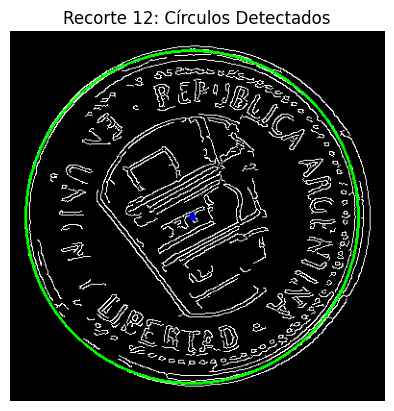

Recorte 12:
  Centro=(189, 193), Radio=173, Área=94024.73


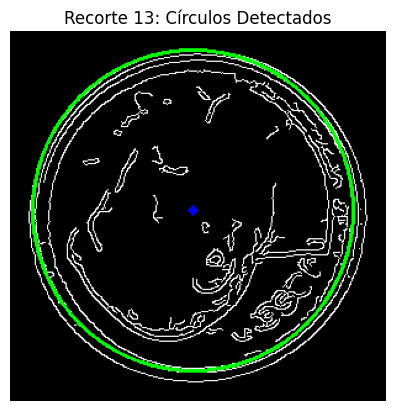

Recorte 13:
  Centro=(148, 145), Radio=130, Área=53092.92


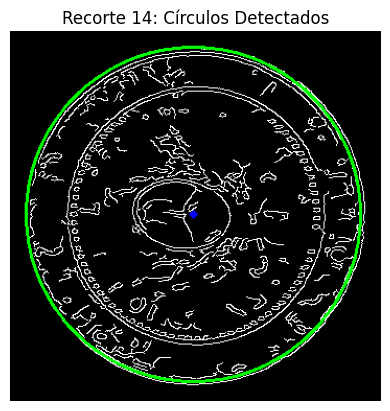

Recorte 14:
  Centro=(175, 175), Radio=160, Área=80424.77


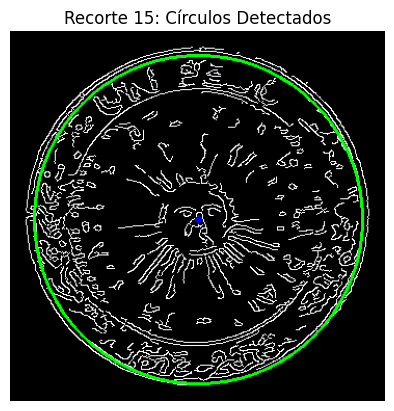

Recorte 15:
  Centro=(181, 181), Radio=158, Área=78426.72


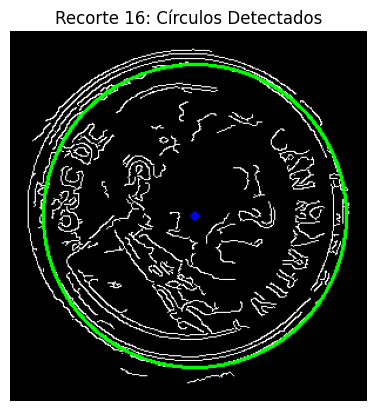

Recorte 16:
  Centro=(157, 157), Radio=129, Área=52279.24


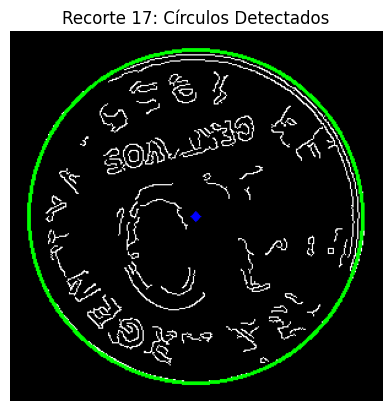

Recorte 17:
  Centro=(151, 151), Radio=136, Área=58106.90


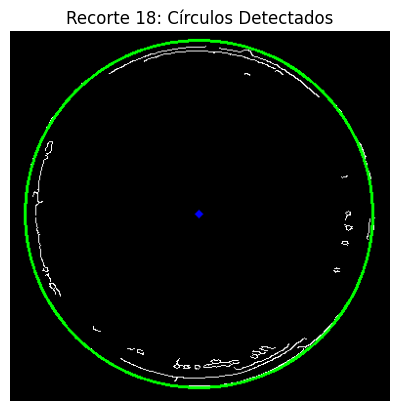

Recorte 18:
  Centro=(193, 187), Radio=178, Área=99538.22
Recorte 19: No se detectaron círculos.

Conteo Final de Monedas:
1 peso: 5
50 centavos: 3
10 centavos: 9

La suma total de las monedas es: $7.40 pesos


In [93]:
# Lista para almacenar los resultados de cada recorte
resultados_recortes = []

# Diccionario para contar las monedas por denominación
conteo_monedas = {
    "1 peso": 0,
    "50 centavos": 0,
    "10 centavos": 0
}

# Iterar sobre cada recorte para aplicar la detección de círculos
for i, recorte in enumerate(recortes):
    # Aplicar la transformada de Hough para detectar círculos en el recorte
    circles = cv2.HoughCircles(
        recorte,  # Trabajamos directamente con la imagen del recorte
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=250,  # Distancia mínima entre círculos dentro del recorte
        param1=100,
        param2=65,  # Más bajo si las monedas no se detectan bien
        minRadius=30,  # Ajustar dependiendo del tamaño de las monedas
        maxRadius=recorte.shape[0] // 2  # Máximo, mitad del tamaño del recorte
    )

    # Verificar si se detectaron círculos
    if circles is not None:
        # Convertir las coordenadas a enteros
        circles = np.round(circles[0, :]).astype("int")
        
        # Dibujar los círculos en el recorte original
        recorte_color = cv2.cvtColor(recorte, cv2.COLOR_GRAY2BGR)
        for (x, y, r) in circles:
            # Dibujar el círculo
            cv2.circle(recorte_color, (x, y), r, (0, 255, 0), 2)
            cv2.circle(recorte_color, (x, y), 2, (255, 0, 0), 3)
            
            # Calcular el área del círculo
            area = np.pi * r**2
            
            # Clasificar según el área
            if 65000 <= area <= 89000:
                conteo_monedas["1 peso"] += 1
            elif area > 90000:
                conteo_monedas["50 centavos"] += 1
            elif 50000 <= area <= 62000:
                conteo_monedas["10 centavos"] += 1

        # Guardar la imagen procesada con círculos detectados
        resultados_recortes.append((i, recorte_color, circles))

        # Mostrar el recorte procesado
        plt.figure()
        plt.imshow(cv2.cvtColor(recorte_color, cv2.COLOR_BGR2RGB))
        plt.title(f"Recorte {i + 1}: Círculos Detectados")
        plt.axis("off")
        plt.show()

        # Imprimir detalles de los círculos detectados
        print(f"Recorte {i + 1}:")
        for (x, y, r) in circles:
            print(f"  Centro=({x}, {y}), Radio={r}, Área={np.pi * r**2:.2f}")
    else:
        print(f"Recorte {i + 1}: No se detectaron círculos.")

print("\nConteo Final de Monedas:")
valor_total = 0  # Inicializar el valor total de las monedas
for tipo, cantidad in conteo_monedas.items():
    valor = 0
    if tipo == "1 peso":
        valor = 1.0
    elif tipo == "50 centavos":
        valor = 0.5
    elif tipo == "10 centavos":
        valor = 0.1
    valor_total += cantidad * valor
    print(f"{tipo}: {cantidad}")

# Mostrar la suma total
print(f"\nLa suma total de las monedas es: ${valor_total:.2f} pesos")


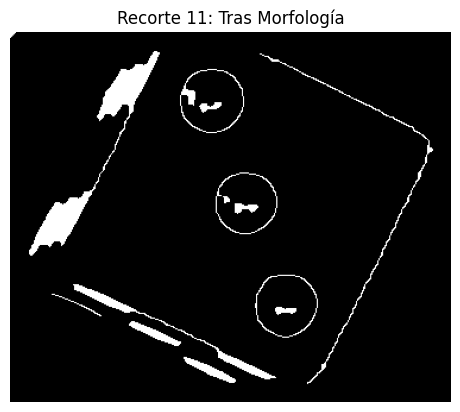

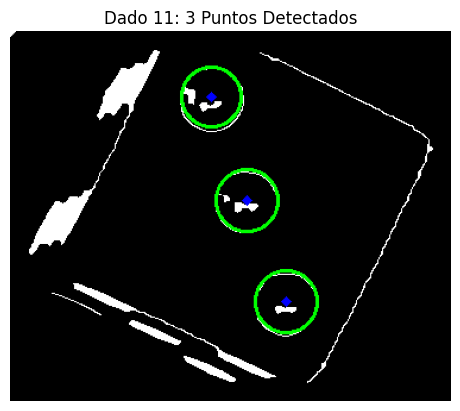

Dado 11: La cara del dado tiene 3 puntos.


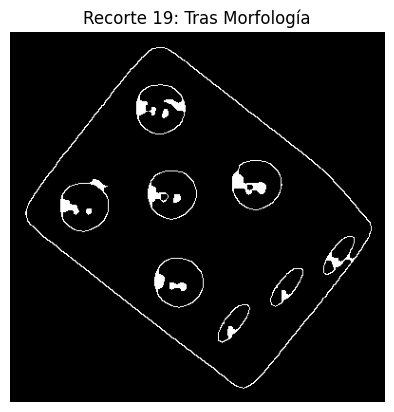

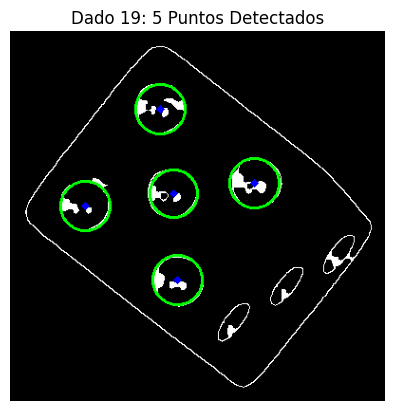

Dado 19: La cara del dado tiene 5 puntos.


In [96]:
# Procesar los recortes donde no se detectaron círculos grandes (monedas)
kernel_apertura = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))  # Más pequeño para apertura
kernel_cierre = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))    # Más grande para cierre
dados_resultados = []
for i, recorte in enumerate(recortes):
    # Verificar si el recorte no corresponde a una moneda
    if all(i != res[0] for res in resultados_recortes):
        # Aplicar operaciones morfológicas para reducir ruido
        recorte_morfo = cv2.morphologyEx(recorte, cv2.MORPH_OPEN, kernel_apertura)
        recorte_morfo = cv2.morphologyEx(recorte_morfo, cv2.MORPH_CLOSE, kernel_cierre)
        
        # Mostrar recorte tras operaciones morfológicas
        plt.figure()
        plt.imshow(recorte_morfo, cmap='gray')
        plt.title(f"Recorte {i + 1}: Tras Morfología")
        plt.axis("off")
        plt.show()

        # Aplicar detección de círculos para los puntos en la cara del dado
        circles = cv2.HoughCircles(
            recorte_morfo,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=80,  # Distancia mínima entre los puntos del dado
            param1=80,   # Parámetro de Canny (puedes ajustar según el ruido)
            param2=30,   # Más bajo para detectar puntos pequeños
            minRadius=5, # Radios pequeños, puntos en la cara del dado
            maxRadius=50
        )

        # Verificar si se detectaron círculos (puntos)
        if circles is not None:
            # Convertir a enteros
            circles = np.round(circles[0, :]).astype("int")

            # Dibujar los puntos en el recorte
            recorte_color = cv2.cvtColor(recorte_morfo, cv2.COLOR_GRAY2BGR)
            for (x, y, r) in circles:
                cv2.circle(recorte_color, (x, y), r, (0, 255, 0), 2)  # Dibujar círculo
                cv2.circle(recorte_color, (x, y), 2, (255, 0, 0), 3)  # Dibujar centro

            # Guardar los resultados
            dados_resultados.append((i, recorte_color, len(circles)))

            # Mostrar la imagen con los círculos detectados
            plt.figure()
            plt.imshow(cv2.cvtColor(recorte_color, cv2.COLOR_BGR2RGB))
            plt.title(f"Dado {i + 1}: {len(circles)} Puntos Detectados")
            plt.axis("off")
            plt.show()

            print(f"Dado {i + 1}: La cara del dado tiene {len(circles)} puntos.")
        else:
            print(f"Dado {i + 1}: No se detectaron puntos.")
